Let's try to make an interpolation class.


The goal is the **cubic spline**, as it is the standard. 

In general, what we want to do is take two lists, $x_i$ and $y_i$, of $N_i$ numbers and construct a function, f(x)=y, that gives $f(x_i)=y_i$ while using a polynomial to return values between $x_i$ and $x_{i+1}$. A spline is an interpolation "method" that uses a different polynomial, $P_i(x)$ for each range $[x_i,x_{j+1})$. For example, the cubic spline uses $P_i(x) = \alpha_i x^3 + \beta_i x^2 + \gamma_i x + \delta_i$. Imposing, continuity conditions for $P_i$ (and it's first and second derivatives), we can find all parameters for all $i=0,1, \dots N-1$.  





In [1]:
import numpy as np

%matplotlib notebook
# %matplotlib widget
import matplotlib.pyplot as plt


plt.rcParams['font.size']=16
plt.rcParams['font.family']='dejavu sans'

plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['mathtext.rm']='custom'
plt.rcParams['mathtext.it']='stix:italic'
plt.rcParams['mathtext.bf']='stix:bold'

It is obvious that splines need some searching method in order to determine which polynomial to evaluate. To do this, we employ the biasection method. For the simplest case, we need to make sure that there are no duplicate entries in the list and that they are in ascending order. Then, given a value x we can find the corresponding x_i from the list using (form [Wikipedia](https://en.wikipedia.org/wiki/Binary_search_algorithm)) 

```python
    inputs: x and X[N]

    L=0
    R=N-1
    while abs(L - R)>=1:
        m = ceil((L+R)/2)
        if X[m] > x:
            R = m - 1
        else:
            L = m
    return L
```

What this does, is bisects the list in order to approach x. That is, you start at the middle point m=ceil((N-1)/2)  (we use ceil to always get an integer, we could do something similar with floor), and check if X[m]>x. If this is true, then you (since X is in ascending order) you go to $m \to \mathrm{ceil}((m-1)/2)$ (ie loop to the lower half of the list), otherwise you go to the upper half $m \to \mathrm{ceil}((m+N-1)/2)$. Effectively, this continues to "bisect" the list until $L=R$ (if $X[L]=X[R]=x$) or $L=R - 1$ (if $X[L]<x<X[R]$).


In [2]:
#let's make a base class that holds the functions we'll need

class Interpolation:
    '''
    Base class for spline interpolation.
    This basic holds the search method, and declares the function (__call__), and the 1st and 2nd derivatives.
    
    the __call__ function here is such that this class corresponds to zeroth order interpolation.
    '''
    def __init__(self,data_x,data_y):
        '''
        data_x: the list for x. Note that I assume that x is sorted in ascending order! 
        data_y: the list for y 
        '''
        self.N=len(data_x)#number of elements
        self.X=[_ for _ in data_x]
        self.Y=[_ for _ in data_y]
        
        #check if X[i-1]<X[i]. This will help with the searching
        for i in range(1,self.N):
            if self.X[i-1]>=self.X[i]:
                print('x must be in increasing order!!!')
                break
    def bSearch(self,x):
        '''
        This function takes a value (x) and finds which polynomial needs to be executed.
        That is it returns i, for x between X[i] and X[i+1]. 
        '''
        L=0
        R=self.N-1
            
        #you can do a bound check, but.. come on!
        #if x<self.X[0]:
        #    print('value:',x,'<',self.X[0])
        #    return 0
        #if x>self.X[self.N-1]:
        #    print('value:',x,'>',self.X[self.N-1])
        #    return self.N-1

        #while int(np.abs(L-R))>=1 
        while L!=R and R-L!=1 :
            m = int(np.ceil((L + R) / 2))
            if self.X[m] > x:
                R = m - 1
            else:
                L = m
        return L

    
    
    def __call__(self,x):
        i=self.bSearch(x)
        return self.Y[i]
    
    
    def derivative_1(self,x):
        return 0
    
    def derivative_2(self,x):
        return 0

Let's start with linear spline, since it is the simplest.

In the linear spline we have
$$
P_i(x) = \alpha_i x + \beta_i,
$$
with $P_i(x_{i,i+1})=y_{i,i+1}$.

This gives us 
$$
P_i(x) = \dfrac{(x-x_{i+1})y_{i}+(x_{i}-x)y_{i+1} }{x_{i}-x_{i+1}}
$$

Notice, that using this method we also get the derivatives for free!
$$
P_i^{\prime}(x) = \dfrac{y_{i+1}-y_{i}}{x_{i}-x_{i+1}} \\
P_i^{(n>0)}(x) = 0
$$




In [3]:
class linearSpline(Interpolation):
    '''
    linear spline interpolation class 
    '''
    def __init__(self,data_x,data_y):
        '''
        data_x: the list for x. Note that I assume that x is sorted in ascending order! 
        data_y: the list for y 
        '''

        Interpolation.__init__(self, data_x,data_y)

    def __call__(self,x):
        i=self.bSearch(x)
        a=(self.X[i+1]-x)/(self.X[i+1]-self.X[i])
        return a*self.Y[i]+(1-a)*self.Y[i+1]
    
    def derivative_1(self,x):
        i=self.bSearch(x)
        return (self.Y[i]-self.Y[i+1])/(self.X[i]-self.X[i+1])

Everything is more or less set. We are not going to do the quadratic spline because the complexity is similar to the cubic one. Additionally, there is brilliant discussion of this in [Numerical Recipes in C++](http://numerical.recipes/book/book.html) (it's free to read online!).




In [4]:
class cubicSpline(Interpolation):
    '''
    cubic spline interpolation class 
    '''
    def __init__(self,data_x,data_y,yp=[]):
        '''
        data_x: the list for x. Note that I assume that x is sorted in ascending order! 
        data_y: the list for y
        yp: first derivatives on the boundaries. If you don't know them, leave it empty 
        '''

        Interpolation.__init__(self, data_x,data_y)
        #these are the tables we need here. y2 are the points of the second derivatives we need to find
        self.y2=[0 for _ in range(self.N)]
        
        #this determines if we use natural boundary conditions
        self.yp=yp[:]
        if len(yp)!=2:
            self.natural=True
        else:
            self.natural=False
        
        #calculate the parameters (the list of second derivatives)
        self.paramCalc()
    
    def paramCalc(self):
        '''This calculates the parameters we need'''
        u=[0 for _ in range(self.N-1)]
        un=0
        qn=0        
        if self.natural:
            #use natural boundary conditions (the second derivatives are set to be zero at the boundaries)
            self.y2[0]=0
        else:
            self.y2[0] = -0.5
            u[0]=(3/(self.X[1]-self.X[0]))*((self.Y[1]-self.Y[0])/(self.X[1]-self.X[0])-self.yp[0])
            
            qn=0.5;
            un=(3/(self.X[self.N-1]-self.X[self.N-2]))*(self.yp[1]-(self.Y[self.N-1]-self.Y[self.N-2])/(self.X[self.N-1]-self.X[self.N-2]))
        
        for i in range(self.N-1):
            sig=(self.X[i]-self.X[i-1])/(self.X[i+1]-self.X[i-1])
            p=sig*self.y2[i-1]+2
            self.y2[i]=(sig-1)/p
            u[i]=(self.Y[i+1]-self.Y[i])/(self.X[i+1]-self.X[i]) - (self.Y[i]-self.Y[i-1])/(self.X[i]-self.X[i-1])
            u[i]=(6*u[i]/(self.X[i+1]-self.X[i-1])-sig*u[i-1])/p
        
        
        self.y2[self.N-1]=(un-qn*u[self.N-2])/(qn*self.y2[self.N-2]+1)
        
        for k in range(self.N-2,-1,-1): #we need k=N-2,N-1,...0
            self.y2[k]=self.y2[k]*self.y2[k+1]+u[k]
        
        
    def __call__(self,x):
        i=self.bSearch(x)
        klo=i
        khi=i+1

        h=self.X[khi]-self.X[klo]
        
        a=(self.X[khi]-x)/h
        b=(x-self.X[klo])/h

        y=a*self.Y[klo]+b*self.Y[khi]
        y+=(a*a*a-a)*self.y2[klo]*(h*h)/6.
        y+=(b*b*b-b)*self.y2[khi]*(h*h)/6.
        
        return y
    
    def derivative_1(self,x):
        i=self.bSearch(x)

        klo=i
        khi=i+1

        h=self.X[khi]-self.X[klo]
        
        a=(self.X[khi]-x)/h
        b=(x-self.X[klo])/h

        dydx=(self.Y[khi]-self.Y[klo])/h
        dydx+=-(3*a*a-1)*self.y2[klo]*h/6.
        dydx+=(3*b*b-1)*self.y2[khi]*h/6.
        
        return dydx
        
    def derivative_2(self,x):
        '''
        If we take the analytical derivative at of self.derivative_1, the result is not good.
        However, since the second derivatives at the data points are known, we can interpolate them
        using linear interpolation. This gives an approximate result!
        '''

        i=self.bSearch(x)
        a=(self.X[i+1]-x)/(self.X[i+1]-self.X[i])
        return a*self.y2[i]+(1-a)*self.y2[i+1]


In [5]:
X=np.linspace(-np.pi,np.pi,100)
Y=np.sin(X)
Yp=np.cos(X)
Ypp=-np.sin(X)


LInt0=Interpolation(X,Y)
LInt1=linearSpline(X,Y)
LInt3=cubicSpline(X,Y) #use natural boundary conditions
# LInt3=cubicSpline(X,Y,[Yp[0],Yp[-1]]) #use first derivatives for the boundary conditions


<IPython.core.display.Javascript object>


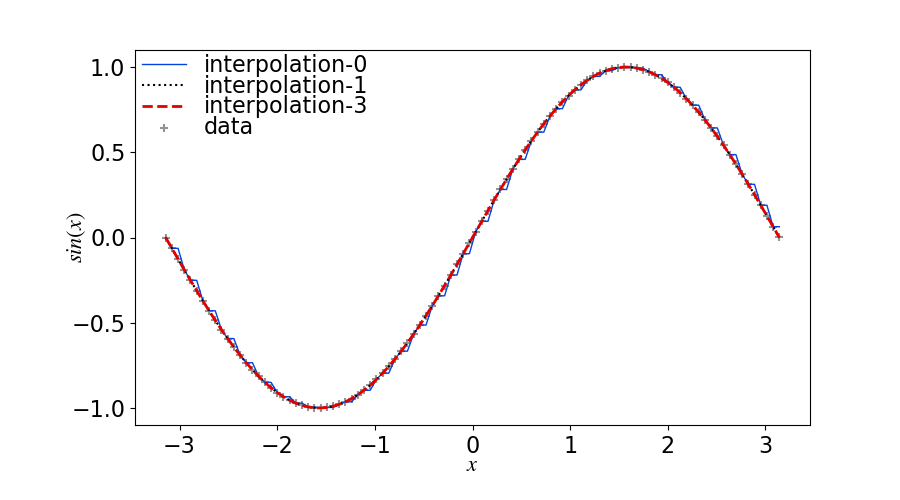

In [6]:
fig=plt.figure(figsize=(9,5))
fig.subplots_adjust(bottom=0.15, left=0.15, top = 0.9, right=0.9,wspace=0.0,hspace=0.0)

sub = fig.add_subplot(1,1,1)

X_int=np.linspace(min(X),max(X),len(X))

Y_0=[LInt0(_) for _ in X_int]
sub.plot(X_int,Y_0,linestyle='-',linewidth=1,alpha=1,c='xkcd:blue',label='interpolation-0')

Y_1=[LInt1(_) for _ in X_int]
sub.plot(X_int,Y_1,linestyle=':',linewidth=1.5,alpha=1,c='xkcd:black',label='interpolation-1')

Y_3=[LInt3(_) for _ in X_int]
sub.plot(X_int,Y_3,linestyle='--',linewidth=2,alpha=1,c='xkcd:red',label='interpolation-3')

sub.scatter(X,Y,linestyle='-',alpha=1,c='xkcd:gray',marker='+',label='data')


sub.legend(bbox_to_anchor=(0.01, 0.99),borderaxespad=0., columnspacing=1,labelspacing=-0.1,
           borderpad=0,ncol=1,loc='upper left' ,framealpha=0)



sub.set_xlabel(r'$x$')
sub.xaxis.set_label_coords(0.5, -0.075) 
sub.set_ylabel(r'$sin(x)$')
sub.yaxis.set_label_coords(-0.07,0.5) 


fig.show()

<IPython.core.display.Javascript object>


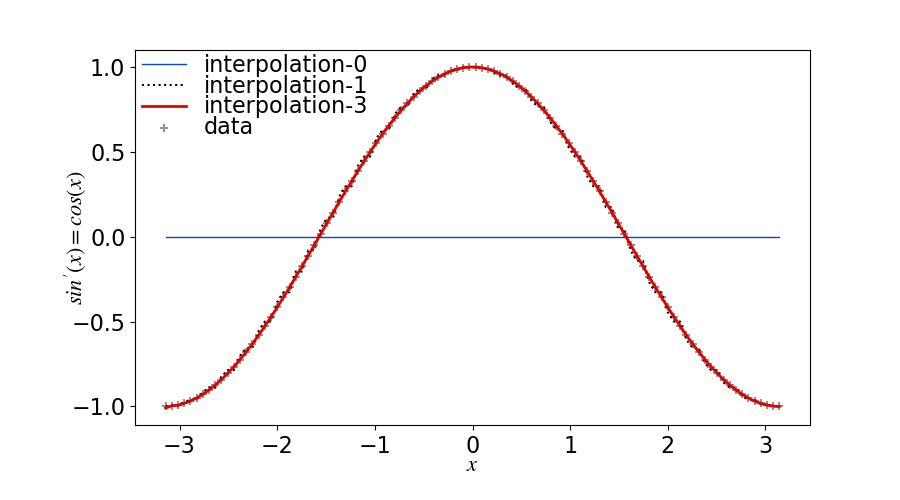

In [7]:
fig=plt.figure(figsize=(9,5))
fig.subplots_adjust(bottom=0.15, left=0.15, top = 0.9, right=0.9,wspace=0.0,hspace=0.0)

sub = fig.add_subplot(1,1,1)


Y_0=[LInt0.derivative_1(_) for _ in X_int]
sub.plot(X_int,Y_0,linestyle='-',linewidth=1,alpha=1,c='xkcd:blue',label='interpolation-0')

Y_1=[LInt1.derivative_1(_) for _ in X_int]
sub.plot(X_int,Y_1,linestyle=':',linewidth=1.5,alpha=1,c='xkcd:black',label='interpolation-1')

Y_3=[LInt3.derivative_1(_) for _ in X_int]
sub.plot(X_int,Y_3,linestyle='-',linewidth=2,alpha=1,c='xkcd:red',label='interpolation-3')

sub.scatter(X,Yp,alpha=1,c='xkcd:gray',marker='+',label='data')



sub.legend(bbox_to_anchor=(0.01, 0.99),borderaxespad=0., columnspacing=1,labelspacing=-0.1,
           borderpad=0,ncol=1,loc='upper left' ,framealpha=0)



sub.set_xlabel(r'$x$')
sub.xaxis.set_label_coords(0.5, -0.075) 
sub.set_ylabel(r'$sin^{\prime}(x)=cos(x)$')
sub.yaxis.set_label_coords(-0.07,0.5) 


fig.show()

<IPython.core.display.Javascript object>


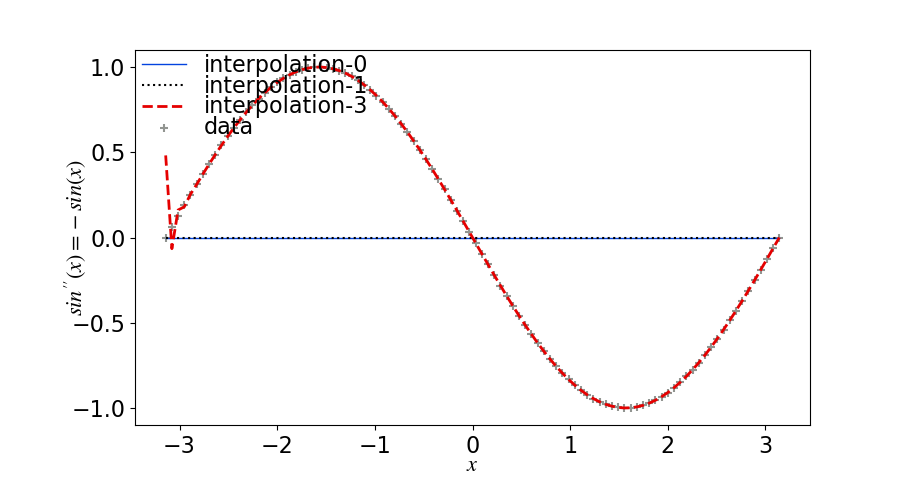

In [8]:
fig=plt.figure(figsize=(9,5))
fig.subplots_adjust(bottom=0.15, left=0.15, top = 0.9, right=0.9,wspace=0.0,hspace=0.0)

sub = fig.add_subplot(1,1,1)


Y_0=[LInt0.derivative_2(_) for _ in X_int]
sub.plot(X_int,Y_0,linestyle='-',linewidth=1,alpha=1,c='xkcd:blue',label='interpolation-0')

Y_1=[LInt1.derivative_2(_) for _ in X_int]
sub.plot(X_int,Y_1,linestyle=':',linewidth=1.5,alpha=1,c='xkcd:black',label='interpolation-1')

Y_3=[LInt3.derivative_2(_) for _ in X_int]
sub.plot(X_int,Y_3,linestyle='--',linewidth=2,alpha=1,c='xkcd:red',label='interpolation-3')

sub.scatter(X,Ypp,linestyle='-',alpha=1,c='xkcd:gray',marker='+',label='data')



sub.legend(bbox_to_anchor=(0.01, 0.99),borderaxespad=0., columnspacing=1,labelspacing=-0.1,
           borderpad=0,ncol=1,loc='upper left' ,framealpha=0)



sub.set_xlabel(r'$x$')
sub.xaxis.set_label_coords(0.5, -0.075) 
sub.set_ylabel(r'$sin^{\prime\prime}(x)=-sin(x)$')
sub.yaxis.set_label_coords(-0.07,0.5) 


fig.show()